In [1]:
import numpy as np 


from cfl.cluster_methods.kmeans import KMeans
from cfl.experiment import Experiment
from visual_bars import generate_visual_bars_data as vbd
from cfl.util.data_processing import one_hot_encode
from cfl.dataset import Dataset

In [2]:
# create a visual bars data set 

n_samples = 10000
noise_lvl = 0.0
im_shape = (10, 10)
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl)

x = vb_data.getImages()
y = vb_data.getTarget()
 
# format data 
x = np.reshape(x, (n_samples, np.prod(im_shape)))
y = one_hot_encode(y, unique_labels=[0,1])

Generating a visual bars dataset with 10000 samples at noise level 0.0


In [102]:
print(x.shape)
print(y.shape)

(10000, 100)
(10000, 2)


All results from this run will be saved to C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test\experiment0011
opt_config not specified in input, defaulting to {}
verbose not specified in input, defaulting to 1
dense_units not specified in input, defaulting to [50, 2]
activations not specified in input, defaulting to ['relu', 'linear']
dropouts not specified in input, defaulting to [0, 0]
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
name not specified in input, defaulting to CondExpVB
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
Training CFL pipeline.
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 5s 622us/sample - loss: 1.4501 - val_loss: 0.1943
Epoch 2/30
7500/7500 [==============================] - 2s 204us/sample - loss: 0.5097 - val_loss: 0.

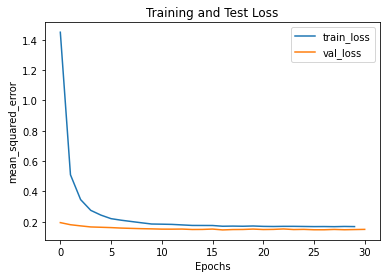

Saving parameters to  C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test\experiment0011\trained_blocks\CondExpVB


In [103]:
# create a CDE-only experiment with visual bars data and train 
data_info = { 'X_dims' : x.shape, 
              'Y_dims' : y.shape, 
              'Y_type' : 'categorical' } 

# CDE parameters
CDE_params = {  'batch_size': 32,
                'optimizer': 'adam', 
                'n_epochs': 30, 
                 }
                            
block_names = ['CondExpVB']
block_params = [CDE_params]

# save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
save_path = 'C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test'
my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)


In [104]:
# load the CDE results  
import joblib
import os
cde_results_dict = joblib.load(os.path.join('/', save_path, 'experiment0007/dataset_train/CondExpVB_results.pickle'))

pyx = cde_results_dict['pyx']
# load CondExpVB_results 
# format is a results dict 
# want the [pyx] from the results 

In [105]:
# pyx is an array n_samples long
# where the first entry in each row is P(y=0 | X=x) and the 
# second entry is P(y=1 | X=x) 
# (the first and second entry of each row roughly add up to 1)
pyx.shape
pyx[:10]

array([[0.4968367 , 0.5029416 ],
       [0.5428738 , 0.45675695],
       [0.04811791, 0.95084274],
       [0.44256657, 0.55704117],
       [0.0821687 , 0.91722846],
       [0.7752958 , 0.2248357 ],
       [0.81293213, 0.18709275],
       [0.36047077, 0.63877225],
       [0.13486803, 0.86466295],
       [0.23128805, 0.7679382 ]], dtype=float32)

In [106]:
# create a number of Kmeans objects with different Ks 
k_range = range(2, 8)

kmeans_l = []
for n_clusters in k_range:
    params = {'n_Xclusters': n_clusters, 'n_Yclusters': 2} 
    kmeans_obj = KMeans('Kmeans', data_info, params, random_state=143)
    kmeans_l.append(kmeans_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for kmeans_obj in kmeans_l: 
  cluster_results = kmeans_obj.train(data, cde_results_dict)
  x_lbls_L.append(cluster_results['x_lbls'])

In [107]:
data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for kmeans_obj in kmeans_l: 
  cluster_results = kmeans_obj.train(data, cde_results_dict)
  x_lbls_L.append(cluster_results['x_lbls'])

In [8]:
import plotly.graph_objects as go

In [109]:
print(names)

['2:', '3:', '4:', '5:', '6:', '7:']


In [110]:
len(x_lbls_L)
len(x_lbls_L[:-1])

5

In [13]:
#### sankey diagram code
# import numpy as np


# load in the cluster labels for each value of n_xclusters
# clusterings = []
# n_clusterings = 8
# bfn = '/Users/imanwahle/Desktop/cfl/examples/lesion_results/experiment000'
# for i in range(n_clusterings):
#     fn = os.path.join(bfn + str(i), 'dataset_test', 'Kmeans_results.pickle')
#     with open(fn, 'rb') as f:
#          clusterings.append(pickle.load(f)['x_lbls'])


# convert cluster labels into source, target, and value information

def convert_lbls_to_sankey_nodes(x_lbls_L):
    # create list of the numbers of clusters used 
    # (the names list looks like ['2:', '3:', '4:', '5:', '6:'] 
    # if Kmeans clustering was done with 2-6 clusters) 
    names = ['{}:'.format(len(np.unique(x_lbls))) for x_lbls in x_lbls_L]

    # label is a list of all the labels on each section of the graph in sequential order 
    # (ie ['2:0', '2:1', '3:0', '3:1', ....])
    # the number after the colon refers to 
    label = [names[0] + str(i) for i in np.unique(x_lbls_L[0])]

    # the Sankey diagram is represented as a graph 
    # where each index of 'source' and 'target' gives a connection between one node and another 
    # and 'value' gives the amount of flow from the source to the target
    source = []
    target = []
    value = []

    
    source_Ls = x_lbls_L[:-1]
    target_Ls = x_lbls_L[1:]
    aindex = 0
    # iterate through each pair of sources and target
    # lists of cluster labels
    for ci,(cA,cB) in enumerate(zip(source_Ls, target_Ls)):
        n1 = names[ci+1]
        bindex = len(label) 

        label = label + [n1 + str(i) for i in np.unique(cB)]

        # add clusters to source and target list 
        for a in range(len(np.unique(cA))):
          for b in range(len(np.unique(cB))):
              source.append(a + aindex)
              target.append(b + bindex)

              #calculate amount of flow between source and target 
              # as 
              value.append(np.sum((cA==a) & (cB==b)))
        aindex = bindex
        link = dict(source = source, target = target, value = value)
    return link, label 


link, label = convert_lbls_to_sankey_nodes(clusterings)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars Clustering with n_clusters 2 to 7", font_size=10)
fig.show()

NameError: name 'clusterings' is not defined

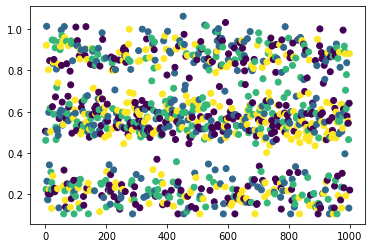

Average prediction for x-class 0: 0.56
Average prediction for x-class 1: 0.56
Average prediction for x-class 2: 0.56
Average prediction for x-class 3: 0.56


In [117]:
import matplotlib.pyplot as plt 

truth = vb_data.getGroundTruth()
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,1])))


# I don't know what to make of this. Is learning 3 distinct types of thing, but what are these? 

In [118]:
# after looking through these images, I realized that the cde/clusterer was doing a really bad job of classifying the images. So I redid with another CDE that learned them better 



In [6]:
# create a visual bars data set 

n_samples = 10000
noise_lvl = 0.0
im_shape = (10, 10)
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl)

x = vb_data.getImages()
y = vb_data.getTarget()
 
# format data 
x = np.expand_dims(x, -1)

y = one_hot_encode(y, unique_labels=[0,1])

Generating a visual bars dataset with 10000 samples at noise level 0.0


All results from this run will be saved to C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test2\experiment0004
lr specified but not used by CondExpKC clusterer
opt_config not specified in input, defaulting to {}
verbose not specified in input, defaulting to 1
dense_units not specified in input, defaulting to [50, 2]
activations not specified in input, defaulting to ['relu', 'linear']
dropouts not specified in input, defaulting to [0, 0]
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
name not specified in input, defaulting to CondExpKC
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
Training CFL pipeline.
Train on 7500 samples, validate on 2500 samples
Epoch 1/3
7500/7500 [==============================] - 3s 428us/sample - loss: 0.1739 - val_loss: 0.1484
Epoch 2/3
7500/7500 [==============================]

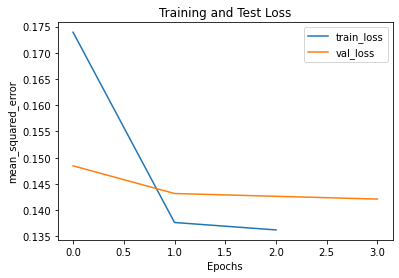

Saving parameters to  C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test2\experiment0004\trained_blocks\CondExpKC


In [7]:
lr = 1e-4 # this was 1e-3 in Chalupka's code
CDE_params = {  'batch_size': 32, # this was 10 in Chalupka's code
                    'lr': lr, 
                    'optimizer': 'adam', 
                    'n_epochs': 3, 
                    # 'standardize': True
                 }
data_info = {'X_dims': x.shape, 
             'Y_dims': y.shape, 
             'Y_type': 'categorical'}

block_names = ['CondExpKC']
block_params = [CDE_params]

# save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
save_path = 'C:/Users/yumen/Documents/Schmidt Academy/cfl/vb_k_test2'
my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)



In [10]:
import joblib
cde_results_dict = joblib.load(os.path.join('/', save_path, 'experiment0004/dataset_train/CondExpKC_results.pickle'))

pyx = cde_results_dict['pyx']


In [11]:
# create a number of Kmeans objects with different Ks 
k_range = range(2, 8)

kmeans_l = []
for n_clusters in k_range:
    params = {'n_Xclusters': n_clusters, 'n_Yclusters': 2} 
    kmeans_obj = KMeans('Kmeans', data_info, params, random_state=143)
    kmeans_l.append(kmeans_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for kmeans_obj in kmeans_l: 
  cluster_results = kmeans_obj.train(data, cde_results_dict)
  x_lbls_L.append(cluster_results['x_lbls'])

In [14]:
link, label = convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars Clustering with n_clusters 2 to 7", font_size=10)
fig.show()

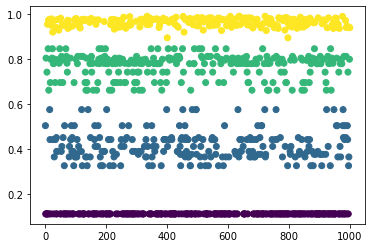

Average prediction for x-class 0: 0.11
Average prediction for x-class 1: 0.43
Average prediction for x-class 2: 0.77
Average prediction for x-class 3: 0.96


In [15]:
import matplotlib.pyplot as plt 

truth = vb_data.getGroundTruth()
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,1])))


# I don't know what to make of this. Is learning 3 distinct types of thing, but what are these? 

In [ ]:
from cfl.visualization_methods import general_vis as vis

